In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [2]:
import hopsworks

project = hopsworks.login() 

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5279


Connected. Call `.close()` to terminate connection gracefully.


In [63]:
feature_view = fs.get_feature_view(
    name = 'stock_prediction_fv',
    version = 1
)

In [65]:
train_data = feature_view.get_training_data(2)[0]
train_data

,date,name,neg,neu,pos,compound,predicted_class,open,high,low,close,adj_close,volume,price_move
0,1424905200000,APPLE,0.065000,0.882667,0.052333,0.070433,1,32.197498,32.717499,31.652500,32.605000,29.465042,365150000,0.0
1,1488236400000,APPLE,0.060000,0.859500,0.080000,0.040450,1,34.270000,34.360001,34.174999,34.247501,32.189495,93931600,1.0
2,1516230000000,APPLE,0.075786,0.859929,0.064357,-0.109086,1,44.842499,45.025002,44.562500,44.814999,42.614571,124773600,0.0
3,1553554800000,APPLE,0.079667,0.841000,0.079444,0.204711,1,47.915001,48.220001,46.145000,46.697498,45.264591,199202000,1.0
4,1579129200000,APPLE,0.036429,0.900429,0.063000,0.277800,1,78.397499,78.925003,78.022499,78.809998,77.208374,108829200,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,1572822000000,APPLE,0.046333,0.880333,0.073333,0.441200,1,64.332497,64.462502,63.845001,64.375000,62.877968,103272000,0.0
2110,1585519200000,APPLE,0.071667,0.861333,0.067000,0.011733,1,62.685001,63.880001,62.349998,63.702499,62.556023,167976400,0.0
2111,1588284000000,APPLE,0.098600,0.820400,0.080600,0.014080,1,71.562500,74.750000,71.462502,72.267502,70.966866,240616800,1.0
2112,1590098400000,APPLE,0.026000,0.917000,0.057000,0.700300,2,78.942497,79.807503,78.837502,79.722504,78.499641,81803200,0.0


In [66]:
train_data.date = train_data.date.apply(lambda x: datetime.fromtimestamp(int(int(x) / 1000)))
train_data = train_data.sort_values(by='date')
train_data

,date,name,neg,neu,pos,compound,predicted_class,open,high,low,close,adj_close,volume,price_move
52,2014-01-28,APPLE,0.051000,0.879000,0.071000,0.923300,2,18.170000,18.392857,17.931070,18.089287,15.947371,1065523200,0.0
337,2014-02-10,APPLE,0.067000,0.885000,0.048000,-0.458800,1,18.523571,18.999643,18.500000,18.892500,16.755165,345559200,1.0
1176,2014-02-11,APPLE,0.088000,0.831000,0.081000,0.222000,1,18.950357,19.205357,18.910713,19.141430,16.975939,282256800,0.0
694,2014-02-21,APPLE,0.000000,0.949000,0.051000,0.790600,2,19.028214,19.091785,18.735714,18.758928,16.636713,278784800,1.0
1768,2014-03-05,APPLE,0.041000,0.931000,0.029000,-0.505000,0,18.961430,19.098213,18.897499,19.012857,16.861912,200062800,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,2022-12-29,APPLE,0.090857,0.849286,0.060143,-0.109700,1,127.989998,130.479996,127.730003,129.610001,129.610001,75703700,1.0
2045,2022-12-30,APPLE,0.073444,0.884444,0.042000,-0.491044,1,128.410004,129.949997,127.430000,129.929993,129.929993,76960600,0.0
750,2023-01-03,APPLE,0.081629,0.870114,0.048171,-0.431311,1,130.279999,130.899994,124.169998,125.070000,125.070000,112117500,1.0
1594,2023-01-04,APPLE,0.075500,0.886100,0.038300,-0.384690,1,126.889999,128.660004,125.080002,126.360001,126.360001,89113600,0.0


In [67]:
train_data = train_data.set_index('date')

In [68]:
train_data.loc[train_data['name'] == 'APPLE']
train_data.drop(['name', 'predicted_class'], axis=1, inplace=True)

In [69]:
train_data

,neg,neu,pos,compound,open,high,low,close,adj_close,volume,price_move
date,,,,,,,,,,,
2014-01-28,0.051000,0.879000,0.071000,0.923300,18.170000,18.392857,17.931070,18.089287,15.947371,1065523200,0.0
2014-02-10,0.067000,0.885000,0.048000,-0.458800,18.523571,18.999643,18.500000,18.892500,16.755165,345559200,1.0
2014-02-11,0.088000,0.831000,0.081000,0.222000,18.950357,19.205357,18.910713,19.141430,16.975939,282256800,0.0
2014-02-21,0.000000,0.949000,0.051000,0.790600,19.028214,19.091785,18.735714,18.758928,16.636713,278784800,1.0
2014-03-05,0.041000,0.931000,0.029000,-0.505000,18.961430,19.098213,18.897499,19.012857,16.861912,200062800,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,0.090857,0.849286,0.060143,-0.109700,127.989998,130.479996,127.730003,129.610001,129.610001,75703700,1.0
2022-12-30,0.073444,0.884444,0.042000,-0.491044,128.410004,129.949997,127.430000,129.929993,129.929993,76960600,0.0
2023-01-03,0.081629,0.870114,0.048171,-0.431311,130.279999,130.899994,124.169998,125.070000,125.070000,112117500,1.0


## <span style="color:#ff5f27;">🧬 Modeling</span>

In [70]:
# Create feature data set
X = train_data
X = np.array(X.drop(['price_move'], 1))

# Create target data set
y = np.array(train_data['price_move'])

In [71]:
split = int(0.8*len(train_data))

X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [72]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1691, 10)
(1691,)
(423, 10)
(423,)


In [73]:
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [74]:
predictions = model.predict(X_test)
predictions

array([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0.

In [75]:
y_test

array([1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [76]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.47      0.32      0.38       209
         1.0       0.50      0.66      0.57       214

    accuracy                           0.49       423
   macro avg       0.49      0.49      0.47       423
weighted avg       0.49      0.49      0.47       423



### Feature Scaling

In [77]:
X_train = scale(X_train)
X_test = scale(X_test)

In [78]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax


-------------- LinearDiscriminantAnalysis ---------------



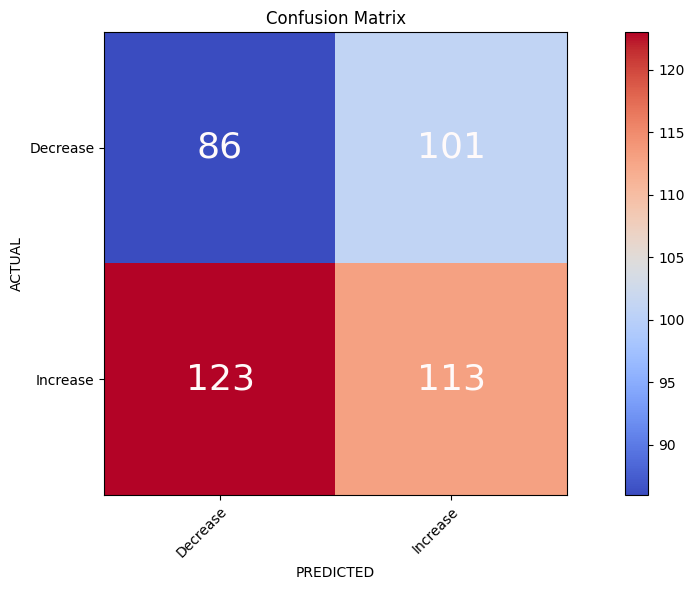

              precision    recall  f1-score   support

    Decrease       0.41      0.46      0.43       187
    Increase       0.53      0.48      0.50       236

    accuracy                           0.47       423
   macro avg       0.47      0.47      0.47       423
weighted avg       0.48      0.47      0.47       423


-------------- SVM Classification ---------------



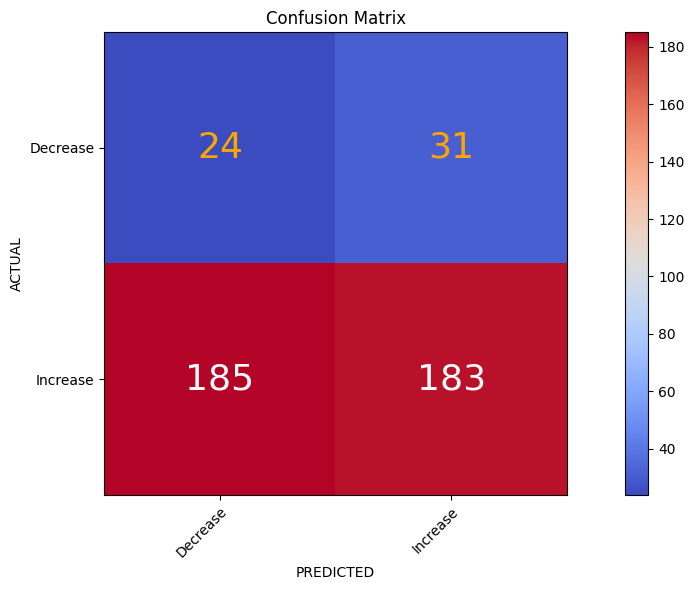

              precision    recall  f1-score   support

    Decrease       0.11      0.44      0.18        55
    Increase       0.86      0.50      0.63       368

    accuracy                           0.49       423
   macro avg       0.48      0.47      0.41       423
weighted avg       0.76      0.49      0.57       423


-------------- SGDClassifier ---------------



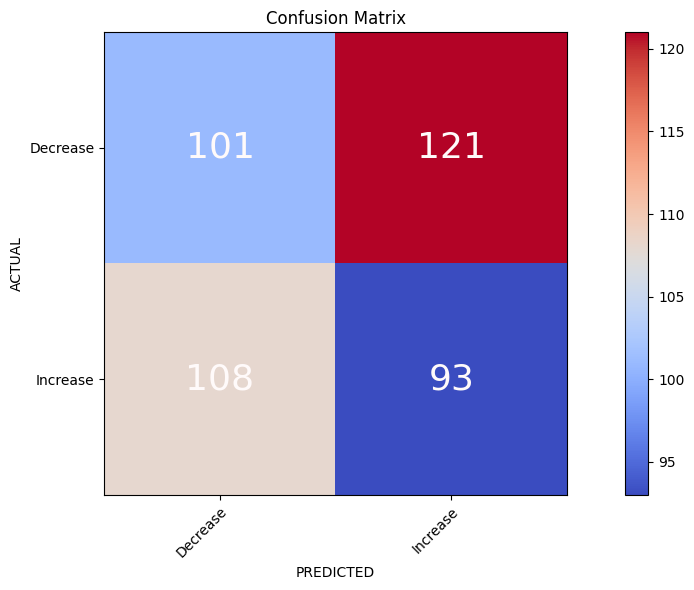

              precision    recall  f1-score   support

    Decrease       0.48      0.45      0.47       222
    Increase       0.43      0.46      0.45       201

    accuracy                           0.46       423
   macro avg       0.46      0.46      0.46       423
weighted avg       0.46      0.46      0.46       423


-------------- KNeighborsClassifier ---------------



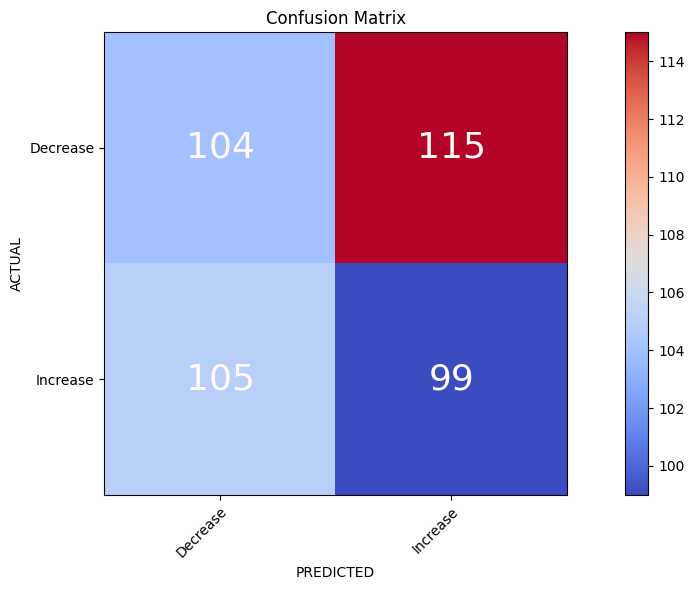

              precision    recall  f1-score   support

    Decrease       0.50      0.47      0.49       219
    Increase       0.46      0.49      0.47       204

    accuracy                           0.48       423
   macro avg       0.48      0.48      0.48       423
weighted avg       0.48      0.48      0.48       423


-------------- GaussianProcessClassifier ---------------



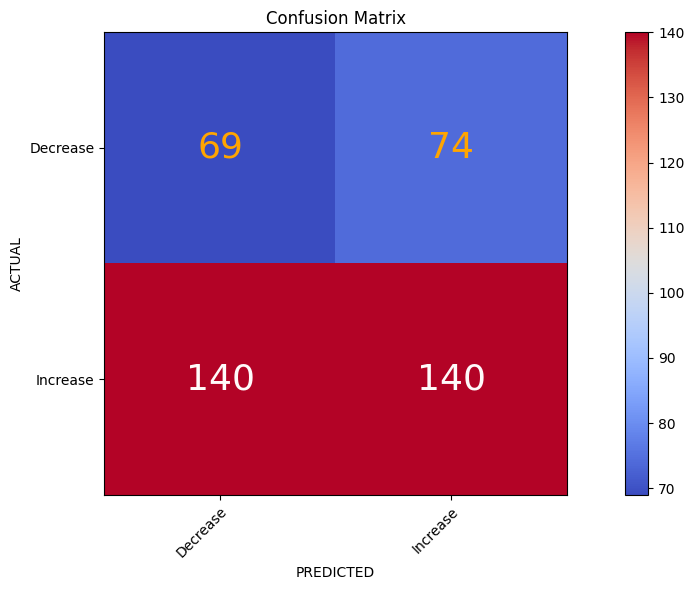

              precision    recall  f1-score   support

    Decrease       0.33      0.48      0.39       143
    Increase       0.65      0.50      0.57       280

    accuracy                           0.49       423
   macro avg       0.49      0.49      0.48       423
weighted avg       0.54      0.49      0.51       423


-------------- RandomForestClassifier ---------------



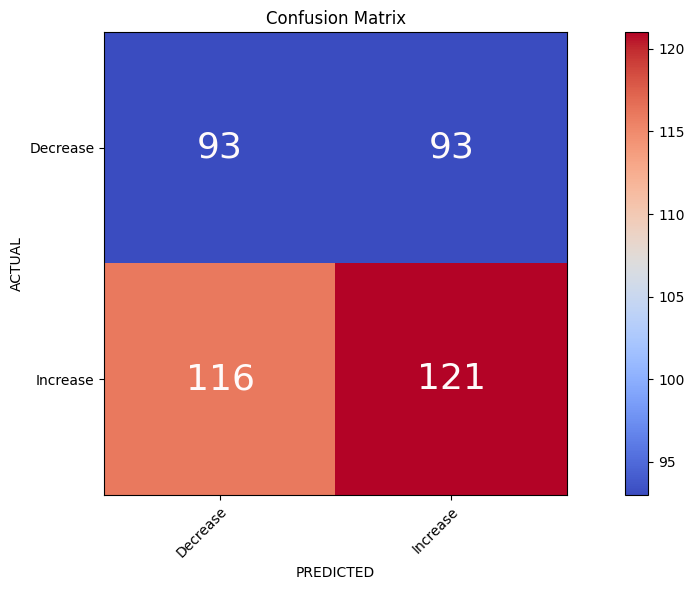

              precision    recall  f1-score   support

    Decrease       0.44      0.50      0.47       186
    Increase       0.57      0.51      0.54       237

    accuracy                           0.51       423
   macro avg       0.51      0.51      0.50       423
weighted avg       0.51      0.51      0.51       423



In [79]:
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_train,y_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_test),y_test, target_names=['Decrease', 'Increase']))